In [ ]:
!unzip images.zip

Archive:  images.zip
   creating: images/
   creating: images/test/
  inflating: images/test/100007.jpg  
  inflating: images/test/100039.jpg  
  inflating: images/test/100099.jpg  
  inflating: images/test/10081.jpg   
  inflating: images/test/101027.jpg  
  inflating: images/test/101084.jpg  
  inflating: images/test/102062.jpg  
  inflating: images/test/103006.jpg  
  inflating: images/test/103029.jpg  
  inflating: images/test/103078.jpg  
  inflating: images/test/104010.jpg  
  inflating: images/test/104055.jpg  
  inflating: images/test/105027.jpg  
  inflating: images/test/106005.jpg  
  inflating: images/test/106047.jpg  
  inflating: images/test/107014.jpg  
  inflating: images/test/107045.jpg  
  inflating: images/test/107072.jpg  
  inflating: images/test/108004.jpg  
  inflating: images/test/108036.jpg  
  inflating: images/test/108069.jpg  
  inflating: images/test/109055.jpg  
  inflating: images/test/112056.jpg  
  inflating: images/test/112090.jpg  
  inflating: images/

In [ ]:
import keras
from keras import backend as K
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

import keras.layers as layers
import keras.models as models
from keras.initializers import orthogonal

from keras.optimizers import SGD, Adam

In [ ]:
batch_size = 20
epochs = 25
input_shape = (256, 256)
noise_factor = 2

In [ ]:
trainingImagePath = '/content/images'
valImagePath = '/content/images'

train_datagen = ImageDataGenerator(
        zoom_range = 0.1,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.5, 1.2],
        shear_range=0.01,
        horizontal_flip=True,
        rescale=1/255,
        fill_mode='reflect',
        data_format='channels_last')

test_datagen = ImageDataGenerator(
        zoom_range = 0.1,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.5, 1.2],
        shear_range=0.01,
        horizontal_flip=True,
        rescale=1/255,
        fill_mode='reflect',
        data_format='channels_last')

training_set = train_datagen.flow_from_directory(
        trainingImagePath,
        target_size=input_shape,
        batch_size=20,
        class_mode='input')

validation_set = train_datagen.flow_from_directory(
        valImagePath,
        target_size=input_shape,
        batch_size=20,
        class_mode='input')

Found 500 images belonging to 3 classes.
Found 500 images belonging to 3 classes.


In [ ]:
def noisy_generator(batches):
    for batch_x, batch_y in batches:
        sigma = np.random.exponential(0.15)
        noise = noise_factor * np.random.normal(scale=sigma, size=batch_x.shape)
        batch_noisy = np.clip(batch_x + noise, 0, 1)
        yield (batch_noisy, batch_y)

In [ ]:
train_noisy_batches = noisy_generator(training_set)
val_noisy_batches = noisy_generator(validation_set)

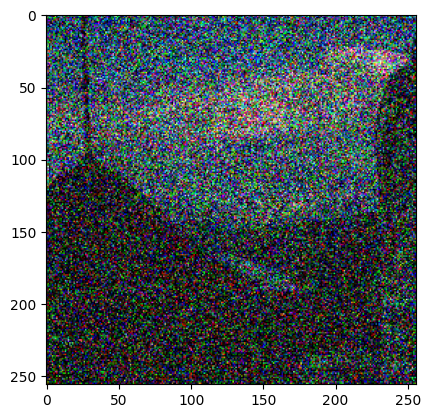

In [ ]:
batch_images, batch_labels = next(train_noisy_batches)
plt.imshow(batch_images[0])

In [ ]:
import keras.layers as layers
import keras.models as models
from keras.initializers import orthogonal


def Conv2DLayer(x, filters, kernel, strides, padding, block_id, kernel_init=orthogonal()):
    prefix = f'block_{block_id}_'
    x = layers.Conv2D(filters, kernel_size=kernel, strides=strides, padding=padding,
                      kernel_initializer=kernel_init, name=prefix+'conv')(x)
    x = layers.LeakyReLU(name=prefix+'lrelu')(x)
    x = layers.Dropout(0.2, name=prefix+'drop')((x))
    x = layers.BatchNormalization(name=prefix+'conv_bn')(x)
    return x

def Transpose_Conv2D(x, filters, kernel, strides, padding, block_id, kernel_init=orthogonal()):
    prefix = f'block_{block_id}_'
    x = layers.Conv2DTranspose(filters, kernel_size=kernel, strides=strides, padding=padding,
                               kernel_initializer=kernel_init, name=prefix+'de-conv')(x)
    x = layers.LeakyReLU(name=prefix+'lrelu')(x)
    x = layers.Dropout(0.2, name=prefix+'drop')((x))
    x = layers.BatchNormalization(name=prefix+'conv_bn')(x)
    return x



def AutoEncoder(input_shape):
    inputs = layers.Input(shape=input_shape)

    # 256 x 256
    conv1 = Conv2DLayer(inputs, 64, 3, strides=1, padding='same', block_id=1)
    conv2 = Conv2DLayer(conv1, 64, 3, strides=2, padding='same', block_id=2)

    # 128 x 128
    conv3 = Conv2DLayer(conv2, 128, 5, strides=2, padding='same', block_id=3)

    # 64 x 64
    conv4 = Conv2DLayer(conv3, 128, 3, strides=1, padding='same', block_id=4)
    conv5 = Conv2DLayer(conv4, 256, 5, strides=2, padding='same', block_id=5)

    # 32 x 32
    conv6 = Conv2DLayer(conv5, 512, 3, strides=2, padding='same', block_id=6)

    # 16 x 16
    deconv1 = Transpose_Conv2D(conv6, 512, 3, strides=2, padding='same', block_id=7)

    # 32 x 32
    skip1 = layers.concatenate([deconv1, conv5], name='skip1')
    conv7 = Conv2DLayer(skip1, 256, 3, strides=1, padding='same', block_id=8)
    deconv2 = Transpose_Conv2D(conv7, 128, 3, strides=2, padding='same', block_id=9)

    # 64 x 64
    skip2 = layers.concatenate([deconv2, conv3], name='skip2')
    conv8 = Conv2DLayer(skip2, 128, 5, strides=1, padding='same', block_id=10)
    deconv3 = Transpose_Conv2D(conv8, 64, 3, strides=2, padding='same', block_id=11)

    # 128 x 128
    skip3 = layers.concatenate([deconv3, conv2], name='skip3')
    conv9 = Conv2DLayer(skip3, 64, 5, strides=1, padding='same', block_id=12)
    deconv4 = Transpose_Conv2D(conv9, 64, 3, strides=2, padding='same', block_id=13)

    # 256 x 256
    skip3 = layers.concatenate([deconv4, conv1])
    conv10 = layers.Conv2D(3, 3, strides=1, padding='same', activation='sigmoid',
                       kernel_initializer=orthogonal(), name='final_conv')(skip3)


    return models.Model(inputs=inputs, outputs=conv10)

In [ ]:
from keras.optimizers import SGD, Adam

model = AutoEncoder((*input_shape, 3))
model_opt = Adam(learning_rate=0.002)
model.compile(optimizer=model_opt, loss='mse', metrics=['accuracy'])

In [ ]:
model.fit(train_noisy_batches,
          steps_per_epoch = training_set.samples // batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=val_noisy_batches,
          validation_steps = training_set.samples // batch_size)

Epoch 1/25
25/25 [==============================] - 48s 2s/step - loss: 0.0310 - accuracy: 0.4727 - val_loss: 0.4786 - val_accuracy: 0.4591
Epoch 2/25
25/25 [==============================] - 35s 1s/step - loss: 0.0151 - accuracy: 0.5504 - val_loss: 0.4773 - val_accuracy: 0.4590
Epoch 3/25
25/25 [==============================] - 34s 1s/step - loss: 0.0121 - accuracy: 0.5531 - val_loss: 0.4858 - val_accuracy: 0.4542
Epoch 4/25
25/25 [==============================] - 39s 2s/step - loss: 0.0083 - accuracy: 0.6058 - val_loss: 0.4814 - val_accuracy: 0.4298
Epoch 5/25
25/25 [==============================] - 35s 1s/step - loss: 0.0098 - accuracy: 0.6244 - val_loss: 0.4146 - val_accuracy: 0.3738
Epoch 6/25
25/25 [==============================] - 34s 1s/step - loss: 0.0077 - accuracy: 0.6475 - val_loss: 0.4101 - val_accuracy: 0.4161
Epoch 7/25
25/25 [==============================] - 34s 1s/step - loss: 0.0073 - accuracy: 0.6607 - val_loss: 0.3180 - val_accuracy: 0.3788
Epoch 8/25
25/25 [==

In [ ]:
test_datagen = ImageDataGenerator(
        zoom_range = 0.1,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.5, 1.2],
        shear_range=0.01,
        horizontal_flip=True,
        rescale=1/255,
        fill_mode='reflect',
        data_format='channels_last')

In [ ]:
test_batches = test_datagen.flow_from_directory(
    '/content/images',
    target_size=(256,256),
    batch_size=20,
    class_mode='input')

test_noisy_batches = noisy_generator(test_batches)

Found 500 images belonging to 3 classes.


In [ ]:
X, y = next(test_noisy_batches)

In [ ]:
score = model.evaluate(X, y, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1/1 [==============================] - 0s 345ms/step - loss: 0.0067 - accuracy: 0.7600
Test loss: 0.0066910311579704285
Test accuracy: 0.7600242495536804


In [ ]:
decoded_imgs = model.predict(X)

1/1 [==============================] - 1s 815ms/step


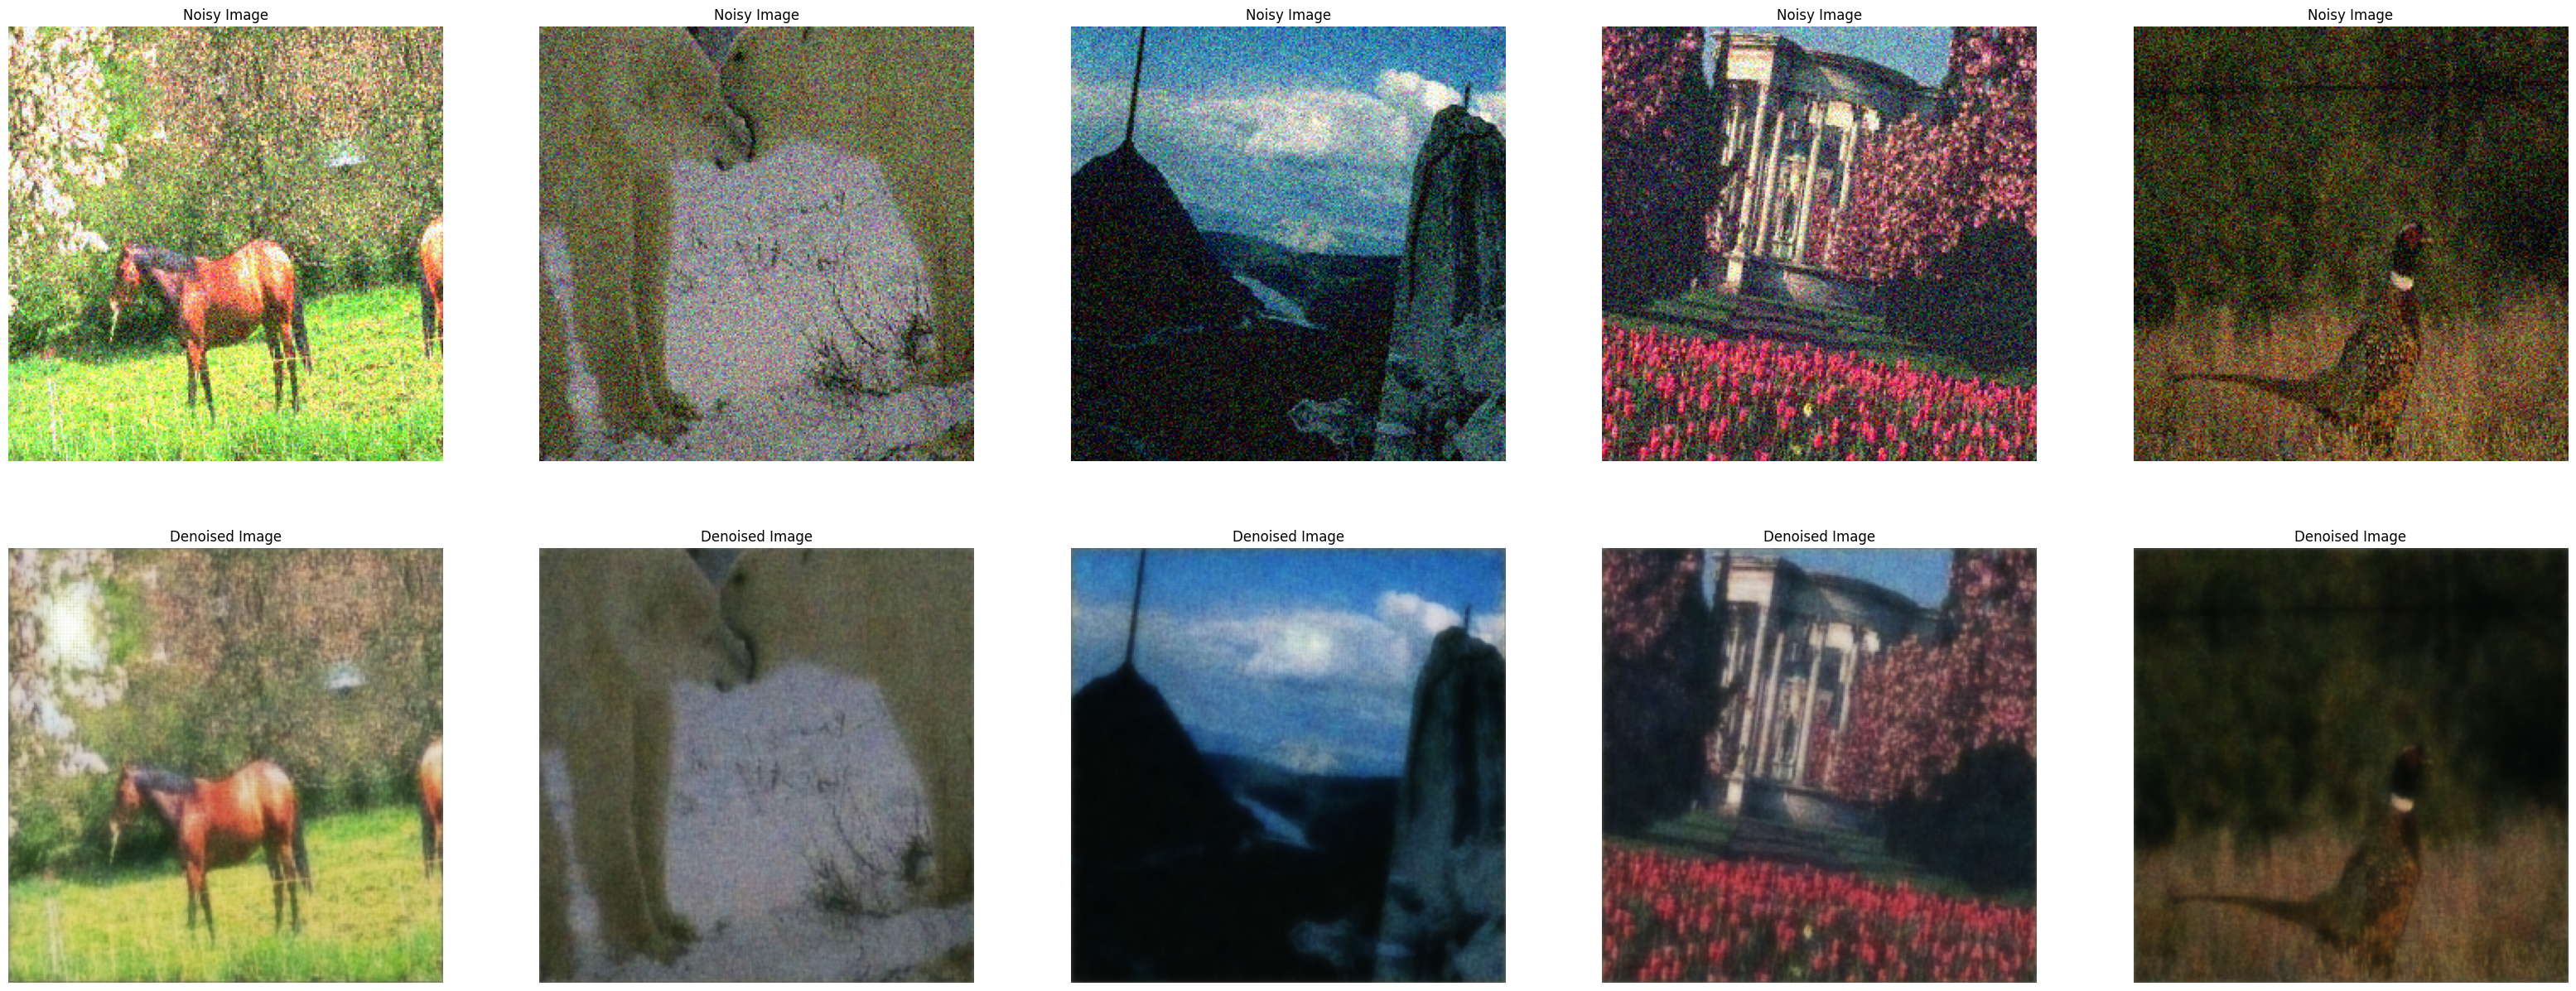

In [ ]:
import matplotlib.pyplot as plt

n = 5

plt.figure(figsize=(40, 15))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X[i])
    plt.title("Noisy Image")
    ax.axis('off')

    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i])
    plt.title("Denoised Image")
    ax.axis('off')

plt.show()